In [22]:
#!pip install seaborn
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import os

In [23]:
kakao = pd.read_csv("카카오.csv")
kakao = kakao.set_index(keys=['Date'], inplace=False, drop=True)
kakao = kakao.iloc[600:]

In [24]:
kakao

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-08,31227.964844,30422.082031,30623.552734,30623.552734,4470991.0,30570.687500
2019-11-11,31227.964844,30623.552734,30825.023438,31026.494141,2530436.0,30972.933594
2019-11-12,31127.228516,30623.552734,31026.494141,30925.757812,1966995.0,30872.371094
2019-11-13,31026.494141,30422.082031,30724.287109,30925.757812,1871035.0,30872.371094
2019-11-14,31227.964844,30623.552734,31127.228516,31127.228516,3233293.0,31073.494141
...,...,...,...,...,...,...
2022-05-18,84000.000000,82500.000000,83700.000000,82600.000000,1208755.0,82600.000000
2022-05-19,81000.000000,80000.000000,80500.000000,80400.000000,1519533.0,80400.000000
2022-05-20,83300.000000,80400.000000,80800.000000,83000.000000,1561541.0,83000.000000


Text(0, 0.5, 'price')

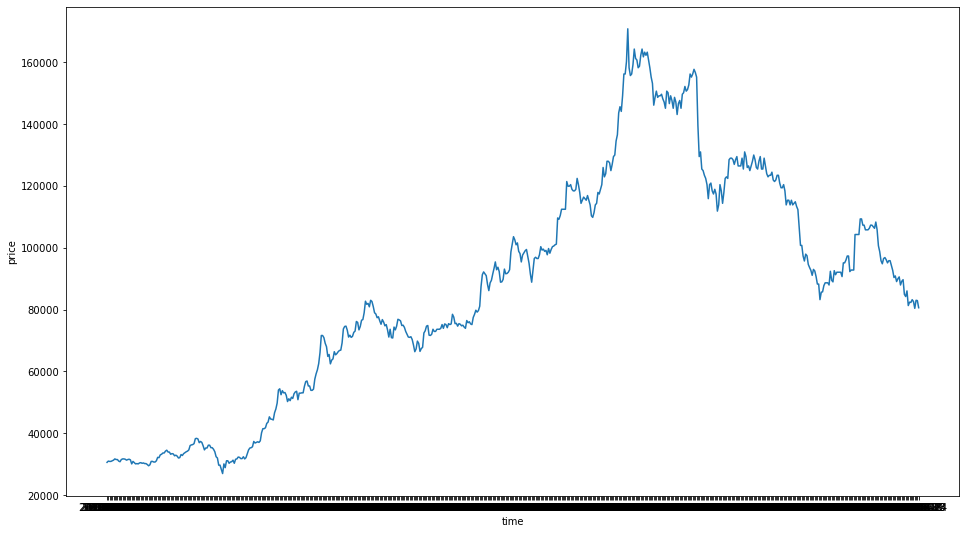

In [25]:
plt.figure(figsize=(16, 9))   #그림 사이즈 조정
sns.lineplot(y=kakao['Close'], x=kakao.index)  #,x,y축 설정
plt.xlabel('time')  #x축 레이블 이름 지정
plt.ylabel('price')  #y축 레이블 이름 지정

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
#scale_cols = ['High', 'Low', 'Open', 'Close', 'Adj Close']
scaled = scaler.fit_transform(kakao[scale_cols])
#scaled = scaler.fit_transform(kakao['Volume'])
scaled

array([[0.01114206, 0.03468635, 0.01939059, 0.02522776, 0.23836116,
        0.02503299],
       [0.01114206, 0.03616236, 0.02077563, 0.02803084, 0.13490469,
        0.02783233],
       [0.01044567, 0.03616236, 0.02216068, 0.02733006, 0.10486606,
        0.02713249],
       ...,
       [0.37111357, 0.40083455, 0.3643363 , 0.38958724, 0.08325016,
        0.38990307],
       [0.37249616, 0.41548695, 0.37739815, 0.38889158, 0.04978085,
        0.38920714],
       [0.36627451, 0.40229979, 0.37602322, 0.37289151, 0.06105577,
        0.37320081]])

In [27]:
kakao = pd.DataFrame(scaled, columns=scale_cols)
kakao

,High,Low,Open,Close,Volume,Adj Close
0,0.011142,0.034686,0.019391,0.025228,0.238361,0.025033
1,0.011142,0.036162,0.020776,0.028031,0.134905,0.027832
2,0.010446,0.036162,0.022161,0.027330,0.104866,0.027132
3,0.009749,0.034686,0.020083,0.027330,0.099750,0.027132
4,0.011142,0.036162,0.022853,0.028732,0.172376,0.028532
...,...,...,...,...,...,...
621,0.375953,0.416220,0.384273,0.386805,0.064442,0.387119
622,0.355214,0.397904,0.362274,0.371500,0.081011,0.371809
623,0.371114,0.400835,0.364336,0.389587,0.083250,0.389903
624,0.372496,0.415487,0.377398,0.388892,0.049781,0.389207


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(kakao.drop('Close', 1), kakao['Close'], test_size=0.3, shuffle=False)

C:\Users\Mgyu\AppData\Local\Temp\ipykernel_23104\3208372521.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(kakao.drop('Close', 1), kakao['Close'], test_size=0.3, shuffle=False)


In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((438, 5), (438,), (188, 5), (188,))

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
WINDOW_SIZE=30
BATCH_SIZE=32

In [32]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [33]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 30, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           #활성화함수를 relu로 정의
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # SimpleRNN
    SimpleRNN(16, activation='tanh'),    ##16개의 SimpleRNN 사용, 활성화함수는 역tan함수
    Dense(16, activation="relu"),   ##16개의 뉴럴넷 사용, 활성화함수는 relu함수
    Dense(1),  #마지막 값은 1개가 도출되어야 하므로 dense(1)을 추가
])

In [36]:
loss = Huber()
optimizer = Adam(0.005) ##3compile 시 optimizer는 adam으로 사용
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50,   #50번 학습
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
      9/Unknown - 2s 6ms/step - loss: 0.0351 - mse: 0.0709
Epoch 1: val_loss improved from inf to 0.00859, saving model to tmp\ckeckpointer.ckpt
13/13 [==============================] - 2s 47ms/step - loss: 0.0263 - mse: 0.0531 - val_loss: 0.0086 - val_mse: 0.0172
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0046
Epoch 2: val_loss improved from 0.00859 to 0.00221, saving model to tmp\ckeckpointer.ckpt
13/13 [==============================] - 0s 22ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 3/50
11/13 [========================>.....] - ETA: 0s - loss: 0.0013 - mse: 0.0025
Epoch 3: val_loss improved from 0.00221 to 0.00061, saving model to tmp\ckeckpointer.ckpt
13/13 [==============================] - 0s 26ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 6.1034e-04 - val_mse: 0.0012
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 7.8348e-04 - mse: 0.0016
Epoch 4: val_loss did not imp

 9/13 [===================>..........] - ETA: 0s - loss: 2.6769e-04 - mse: 5.3538e-04
Epoch 29: val_loss did not improve from 0.00024
13/13 [==============================] - 0s 11ms/step - loss: 2.7687e-04 - mse: 5.5373e-04 - val_loss: 2.3808e-04 - val_mse: 4.7617e-04
Epoch 30/50
10/13 [======================>.......] - ETA: 0s - loss: 2.2296e-04 - mse: 4.4593e-04
Epoch 30: val_loss did not improve from 0.00024
13/13 [==============================] - 0s 11ms/step - loss: 2.1635e-04 - mse: 4.3271e-04 - val_loss: 2.4653e-04 - val_mse: 4.9306e-04
Epoch 31/50
10/13 [======================>.......] - ETA: 0s - loss: 2.2757e-04 - mse: 4.5515e-04
Epoch 31: val_loss did not improve from 0.00024
13/13 [==============================] - 0s 11ms/step - loss: 2.2924e-04 - mse: 4.5848e-04 - val_loss: 2.7469e-04 - val_mse: 5.4938e-04
Epoch 32/50
10/13 [======================>.......] - ETA: 0s - loss: 2.0141e-04 - mse: 4.0283e-04
Epoch 32: val_loss did not improve from 0.00024
13/13 [=============

In [39]:
pred = model.predict(test_data)

In [40]:
pred.shape

(158, 1)

In [41]:
y_test

438    0.835319
439    0.807288
440    0.831815
441    0.838823
442    0.821303
         ...   
621    0.386805
622    0.371500
623    0.389587
624    0.388892
625    0.372892
Name: Close, Length: 188, dtype: float64

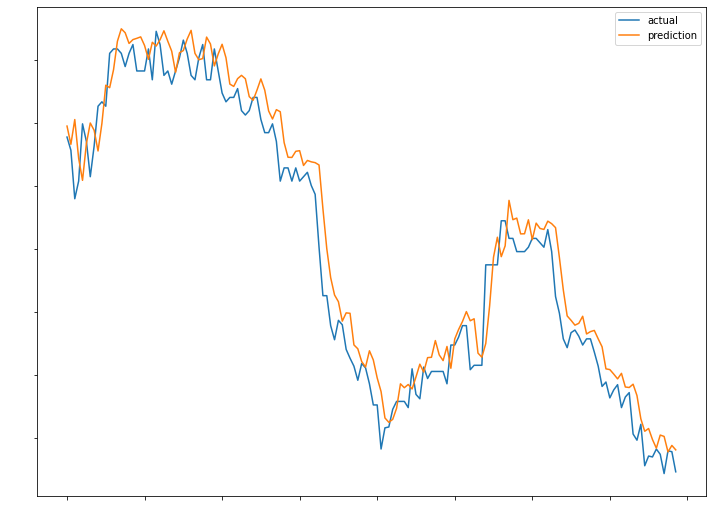

In [65]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[30:], label='actual')
plt.plot(pred, label='prediction')
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.legend()
plt.show()

In [49]:
np.asarray(y_test)[30:]

array([0.639103  , 0.62859143, 0.59004903, 0.60406447, 0.64961456,
       0.63559912, 0.60756829, 0.6320953 , 0.66362995, 0.66713382,
       0.66362995, 0.70567622, 0.70918009, 0.70918009, 0.70567622,
       0.69516465, 0.70567622, 0.71268391, 0.69166083, 0.69166083,
       0.69166083, 0.70918009, 0.68465309, 0.72319548, 0.71268391,
       0.68815696, 0.69166083, 0.68114927, 0.69166083, 0.70217235,
       0.71618779, 0.70567622, 0.68815696, 0.68465309, 0.70217235,
       0.71268391, 0.68465309, 0.68465309, 0.70918009, 0.69166083,
       0.67414152, 0.66713382, 0.6706377 , 0.6706377 , 0.67764539,
       0.66012613, 0.65662226, 0.66012613, 0.6706377 , 0.6706377 ,
       0.65311844, 0.64260687, 0.64260687, 0.64961456, 0.63559912,
       0.60406447, 0.61457604, 0.61457604, 0.60406447, 0.61457604,
       0.60406447, 0.60756829, 0.61107217, 0.6005606 , 0.59355291,
       0.55150664, 0.51296424, 0.51296424, 0.48913805, 0.47792572,
       0.49334269, 0.48983881, 0.47021721, 0.46320951, 0.45690

In [52]:
def MSE(y_test, y_pred):
    return np.mean(np.square((y_test - y_pred)))

MSE(np.asarray(y_test)[30:], pred)

0.02346632931522957

In [56]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.asarray(y_test)[30:], pred):.3f}")

MAPE: 23.812


In [58]:
def MPE(y_test, y_pred): 
    return np.mean((y_test - y_pred) / y_test) * 100
MPE(np.asarray(y_test)[30:], pred)

-6.796033025238518